# **<span style="color: #87CEEB;"> CS437/CS5317/EE414/EE513 Deep Learning Programming Assignment 1</span>**

# <span style="color: #9370DB;">**Submission Guidelines**</span>

- <span style="color: #9370DB;">Please rename the file to `<RollNumber>_PA1_2_3`.</span>
- <span style="color: #9370DB;">Please also submit a **.py** file of every Notebook. You can do this by exporting your **ipynb** to a Python script.</span>
- <span style="color: #9370DB;">Please submit a zipped folder of both your Jupyter Notebooks and Python script files.</span>




### Name: Muhammad Abubakar Mughal  
### Roll Number: 26100228

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import glob
import cv2
import os

from torchsummary import summary
from tqdm.notebook import tqdm


<h1><b> Part 2 Task 3 : Sparse CNN Layers<span style="color: #9370DB;"> (50 Points Total)</span></b></h1> 

In this section, you will classify CIFAR-10 ising sparse CNN. You will replace the standard CNN layers with sparse CNN layers. Sparse CNN layers are useful for reducing the number of parameters in the model, which can lead to faster inference times and lower memory usage. It would be helpful to have a look of this article to explor more about sparse CNN: https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Liu_Sparse_Convolutional_Neural_2015_CVPR_paper.pdf

You are required to implement a sparse CNN layer by applying pruning to the weights of the convolutional layers. PyTorch provides utilities for pruning in the `torch.nn.utils.prune` module.

## Task:
1. Implement a sparse CNN layer by applying pruning to the weights of the convolutional layers.
3. Train the model with the sparse CNN layers and compare its performance with the original model.

Here you need to implement Sparse CNN Layer using PyTorch's pruning utilities.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune

class SparseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, pruning_amount=0.5):
        super(SparseConv2d, self).__init__()
        # ================= Your Code Here ===============
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        prune.l1_unstructured(self.conv, name="weight", amount=pruning_amount)
        # =================================================


    def forward(self, x):
        # ================= Your Code Here ===============
        return self.conv(x)
        # =================================================



In [8]:
import torch
import torch.nn as nn

class SparseModel(nn.Module):
    def __init__(self):
        super().__init__()
        # ================= Your Code Here ===============
        
        self.conv1 = SparseConv2d(3, 32, kernel_size=3, stride=1, padding=1, pruning_amount=0.6)

        self.conv2 = SparseConv2d(32, 64, kernel_size=3, stride=1, padding=1, pruning_amount=0.7)
        
        self.conv3 = SparseConv2d(64, 128, kernel_size=3, stride=1, padding=1, pruning_amount=0.6)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10) 
        self.dropout = nn.Dropout(0.4)
    # =================================================

        
    def forward(self, x):
        # ================= Your Code Here ===============
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        # ================================================


Download CIFAR-10, use the SparseConv2d layer instead of the standard nn.Conv2d layer.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((64, 64)), #resizing according to expected input 
    transforms.ToTensor(),
    transforms.Normalize([0.5 , 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ============ YOUR CODE HERE ============

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# ========================================

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of testing samples: 10000


# Train your Sparse CNN
In this section, you are required to train your Sparse CNN on the Pokemon Dataset. You may change the `criterion`, `optimizer`, `lr` and `NUM_EPOCHS`.
You have to implement the model training for each epoch.

In [10]:
sparse_model = SparseModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sparse_model.parameters(), lr=0.001, weight_decay = 1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sparse_model.to(device)

summary(sparse_model, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
      SparseConv2d-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
      SparseConv2d-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
      SparseConv2d-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 256]       2,097,408
          Dropout-11                  [-1, 256]               0
           Linear-12                   [-1, 10]           2,570
Total params: 2,193,226
Trainable params: 2,193,226
Non-trainable params: 0
---------------------------

In [ ]:
sparse_model.train()
NUM_EPOCHS = 20

loss_list = []
accuracy_list = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = sparse_model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100.0 * correct / total

    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.2f}%")

print("Training complete! 🎉")

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: Loss = 1.5416, Accuracy = 43.96%
Epoch 2/20: Loss = 1.2545, Accuracy = 54.58%
Epoch 3/20: Loss = 1.1142, Accuracy = 60.34%
Epoch 4/20: Loss = 1.0263, Accuracy = 63.84%
Epoch 5/20: Loss = 0.9503, Accuracy = 66.55%
Epoch 6/20: Loss = 0.8982, Accuracy = 68.27%
Epoch 7/20: Loss = 0.8571, Accuracy = 69.81%
Epoch 8/20: Loss = 0.8237, Accuracy = 70.90%
Epoch 9/20: Loss = 0.7900, Accuracy = 72.28%
Epoch 10/20: Loss = 0.7619, Accuracy = 73.46%
Epoch 11/20: Loss = 0.7420, Accuracy = 73.87%
Epoch 12/20: Loss = 0.7141, Accuracy = 74.89%
Epoch 13/20: Loss = 0.7059, Accuracy = 75.23%
Epoch 14/20: Loss = 0.6862, Accuracy = 75.98%
Epoch 15/20: Loss = 0.6713, Accuracy = 76.44%
Epoch 16/20: Loss = 0.6550, Accuracy = 76.98%
Epoch 17/20: Loss = 0.6430, Accuracy = 77.42%
Epoch 18/20: Loss = 0.6258, Accuracy = 78.04%
Epoch 19/20: Loss = 0.6226, Accuracy = 78.10%
Epoch 20/20: Loss = 0.6125, Accuracy = 78.53%
Training complete! 🎉


# Evaluate your Sparse CNN
In this section, you will set your Sparse model in evaluation mode and evaluate it on your test data. 
You have to implement the evaluation loop and report the test accuracy.

In [ ]:
sparse_model.eval()
correct = 0
total = 0

with torch.no_grad(): 
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  
        
        outputs = sparse_model(inputs)  
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 

test_accuracy = 100 * correct / total
print(f"Test Accuracy of Sparse Model: {test_accuracy:.2f}%")

Test Accuracy of Sparse Model: 76.77%


Evaluate Spare model performance and mofidy the code where it necessary

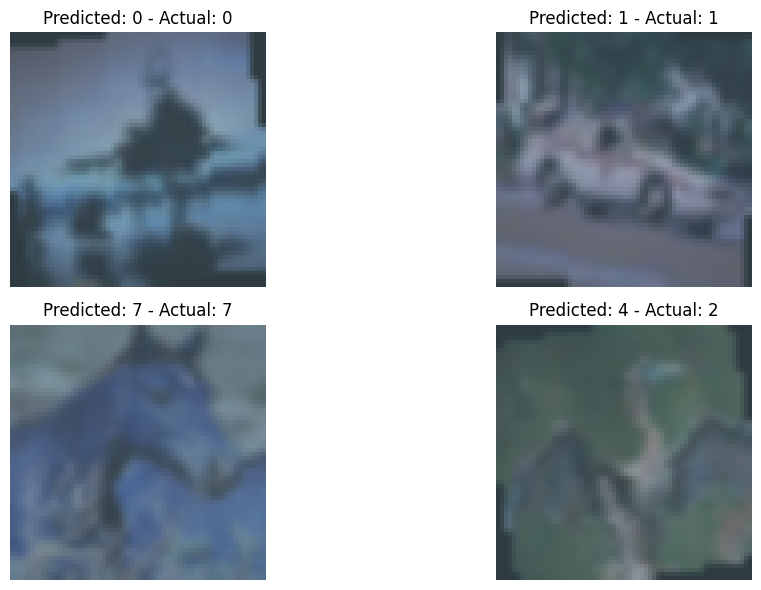

In [ ]:
sparse_model.eval()

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, (image, label) in enumerate(list(testloader)[:4]):

    image = image.to(device)
    label = label.to(device)

    output = sparse_model(image) 

    _, predicted_label = torch.max(output, 1)

    for j in range(min(image.size(0), 4)): 
        img = image[j] 
        actual_label = label[j]  

        img = img.permute(1, 2, 0).cpu().numpy()

        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img *= 255
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        ax = axes[j // 2, j % 2]
        ax.imshow(img)
        ax.set_title(f"Predicted: {predicted_label[j].item()} - Actual: {actual_label.item()}") 
        ax.axis("off")

plt.tight_layout()

plt.show()

# Reflection Questions

1. What is the trade-off between model sparsity and accuracy?

Sparse Models require a lot less memory and are more efficient training wise. However, they suffer from reduced accuracy due to their limited capability. Evaluating the results of my own Sparse implementation, it held up really well in comparison to normal CNN implementation despite being much more constrained. It is much faster too and was able to produce results close to that of the normal CNN (albeit with 20 epochs i.e 10 more than the normal one).
   
2. How does pruning affect the training time and inference speed?

Training time is almost 1/4th of that of the normal CNN. Similarly, inference speed is much faster as well since most of the unimportant weights of neurons were neutralized. 
